In [1]:
# Importing the libraries
import pymysql
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, accuracy_score

from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")

### Extracting the Data from Database

In [2]:
# Database connection details
host = '18.136.157.135'
port = 3306
user = 'dm_team2'
password = 'DM!$Team&27@9!20!'
database = 'project_sales'

# Connect to the database
connection = pymysql.connect(host=host, port=port, user=user, password=password, database=database)

try:
    # Query to retrieve data from the 'data' table
    query = "SELECT * FROM data"

    # Execute the query and fetch data into a pandas DataFrame
    X_test = pd.read_sql(query, connection)

finally:
    # Close the database connection
    connection.close()

In [3]:
X_test.head()

,Created,Product_ID,Source,Mobile,EMAIL,Sales_Agent,Location,Delivery_Mode,Status
0,14-11-2018 10:05,,Website,984XXXXXXX,aXXXXXXX@gmail.com,Sales-Agent-11,,Mode-5,Open
1,14-11-2018 09:22,,Website,XXXXXXX,#VALUE!,Sales-Agent-10,,Mode-5,Open
2,14-11-2018 09:21,,Website,XXXXXXX,dXXXXXXX@yahoo.com,Sales-Agent-10,,Mode-5,Open
3,14-11-2018 08:46,,Website,XXXXXXX,wXXXXXXX@gmail.com,Sales-Agent-10,,Mode-5,Open
4,14-11-2018 07:34,,Website,XXXXXXX,cXXXXXXX@gmail.com,Sales-Agent-10,,Mode-5,Open


### Basic Checks

In [4]:
print("Number of rows:",X_test.shape[0])
print("Number of columns:",X_test.shape[1])

Number of rows: 7422
Number of columns: 9


In [5]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7422 entries, 0 to 7421
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Created        7422 non-null   object
 1   Product_ID     7422 non-null   object
 2   Source         7422 non-null   object
 3   Mobile         7422 non-null   object
 4   EMAIL          7422 non-null   object
 5   Sales_Agent    7422 non-null   object
 6   Location       7422 non-null   object
 7   Delivery_Mode  7422 non-null   object
 8   Status         7422 non-null   object
dtypes: object(9)
memory usage: 522.0+ KB


In [6]:
# Basic data types of the attributes
X_test.dtypes

Created          object
Product_ID       object
Source           object
Mobile           object
EMAIL            object
Sales_Agent      object
Location         object
Delivery_Mode    object
Status           object
dtype: object

In [7]:
# Count of null values
X_test.isnull().sum()

Created          0
Product_ID       0
Source           0
Mobile           0
EMAIL            0
Sales_Agent      0
Location         0
Delivery_Mode    0
Status           0
dtype: int64

In [8]:
# Count of duplicate values
X_test.duplicated().sum()

2

In [9]:
# Statistical data description
X_test.describe()

,Created,Product_ID,Source,Mobile,EMAIL,Sales_Agent,Location,Delivery_Mode,Status
count,7422,7422,7422,7422,7422,7422,7422,7422,7422
unique,6752,30,26,487,883,13,18,5,11
top,26-09-2018 11:30,18,Call,,#VALUE!,Sales-Agent-4,Other Locations,Mode-5,Junk Lead
freq,4,1711,2547,1810,1701,1500,2500,2975,1536


### Data Cleaning

In [10]:
# Assuming "CreatedProduct_ID" has string timestamps
X_test['Created'] = pd.to_datetime(X_test['Created'], dayfirst=True)

As we know there is no such information in the "Mobile" and "Email" column, so we can drop this column.

In [11]:
# Dropping 'Mobile' and 'EMAIL' column from the dataset
X_test.drop(['Mobile', 'EMAIL'],axis=1, inplace=True)

The null values in this dataset are represented as an empty strings ' '. <br/>

In [12]:
# Extracting the number of empty strings in each column of the dataset
print(X_test.eq('').sum())

Created           0
Product_ID       58
Source           17
Sales_Agent      23
Location         58
Delivery_Mode     0
Status            0
dtype: int64



As we can see that there are values like these in most of the columns, where there is no data in columns. <br/>
Now we'll first replace these empty strings with standard Nan values

In [13]:
# Replace all empty strings with NaN across the entire DataFrame
X_test = X_test.replace('', np.nan)

In [14]:
# Checking the null values now
X_test.isnull().sum()

Created           0
Product_ID       58
Source           17
Sales_Agent      23
Location         58
Delivery_Mode     0
Status            0
dtype: int64

Now we can replace or impute these null values easily.

In [15]:
# Checking the value counts of the sources of the leads in percentage
X_test['Source'].value_counts(normalize=True)*100

Source
Call                             34.395679
Live Chat-Direct                 24.767049
Website                          21.525996
Live Chat-Google Organic          3.700203
Live Chat -PPC                    3.362593
Live Chat-Blog                    3.200540
Customer Referral                 2.430790
US Website                        1.850101
Just Dial                         0.756246
Existing Client                   0.688724
Personal Contact                  0.675219
Live Chat-CPC                     0.675219
By Recommendation                 0.432140
CRM form                          0.310601
Existing Customer                 0.297097
Live Chat-Google Ads              0.283592
Campaign                          0.256583
E-mail Campaign                   0.162053
Live Chat-Adwords Remarketing     0.094531
Live Chat-Quora                   0.027009
Other                             0.027009
SMS Campaign                      0.027009
Live Chat-Youtube                 0.027009
E-Ma

As we can see only 'Call', 'Live Chat-Direct', 'Website' have significant portions. So we can write the remaining categories as 'Others'.

In [16]:
# Define sources to keep separate
sources_to_keep = ['Call', 'Live Chat-Direct', 'Website']

# Define replacement string for other sources
replacement_string = 'OTHERS'

# Create a function to categorize sources
def categorize_source(source):
  if source in sources_to_keep:
    return source
  else:
    return replacement_string

# Apply the function to the 'Source' column
X_test['Source'] = X_test['Source'].apply(categorize_source)

In [17]:
X_test['Status'].value_counts(normalize=True)*100

Status
Junk Lead               20.695230
Not Responding          15.211533
CONVERTED               11.236863
Just Enquiry            10.239828
Potential                9.539208
Long Term                8.703853
In Progress Positive     8.663433
In Progress Negative     8.434384
LOST                     5.928321
Open                     1.104823
converted                0.242522
Name: proportion, dtype: float64

As we can see the there are status of "CONVERTED' and 'converted' which are same. We can add them together in one.

In [18]:
# Identifying rows with "converted" status (case-sensitive)
converted_rows = X_test[X_test['Status'] == 'converted']

# Updating the status in those rows to "CONVERTED" (uppercase)
converted_rows['Status'] = 'CONVERTED'

# Updating the DataFrame with the modified rows (can be done in-place)
X_test.update(converted_rows)

# Verifying the change
print(X_test['Status'].value_counts())

Status
Junk Lead               1536
Not Responding          1129
CONVERTED                852
Just Enquiry             760
Potential                708
Long Term                646
In Progress Positive     643
In Progress Negative     626
LOST                     440
Open                      82
Name: count, dtype: int64


In [19]:
X_test.describe(include='all')

,Created,Product_ID,Source,Sales_Agent,Location,Delivery_Mode,Status
count,7422,7364,7422,7399,7364,7422,7422
unique,NaN,29,4,12,17,5,10
top,NaN,18,Call,Sales-Agent-4,Other Locations,Mode-5,Junk Lead
freq,NaN,1711,2547,1500,2500,2975,1536
mean,2018-07-31 21:27:37.849636352,NaN,NaN,NaN,NaN,NaN,NaN
min,2018-04-28 07:54:00,NaN,NaN,NaN,NaN,NaN,NaN
25%,2018-06-12 15:32:00,NaN,NaN,NaN,NaN,NaN,NaN
50%,2018-07-30 11:39:30,NaN,NaN,NaN,NaN,NaN,NaN
75%,2018-09-18 14:03:45,NaN,NaN,NaN,NaN,NaN,NaN
max,2018-11-14 10:05:00,NaN,NaN,NaN,NaN,NaN,NaN


## Data Visualization

### What were the lead sources?

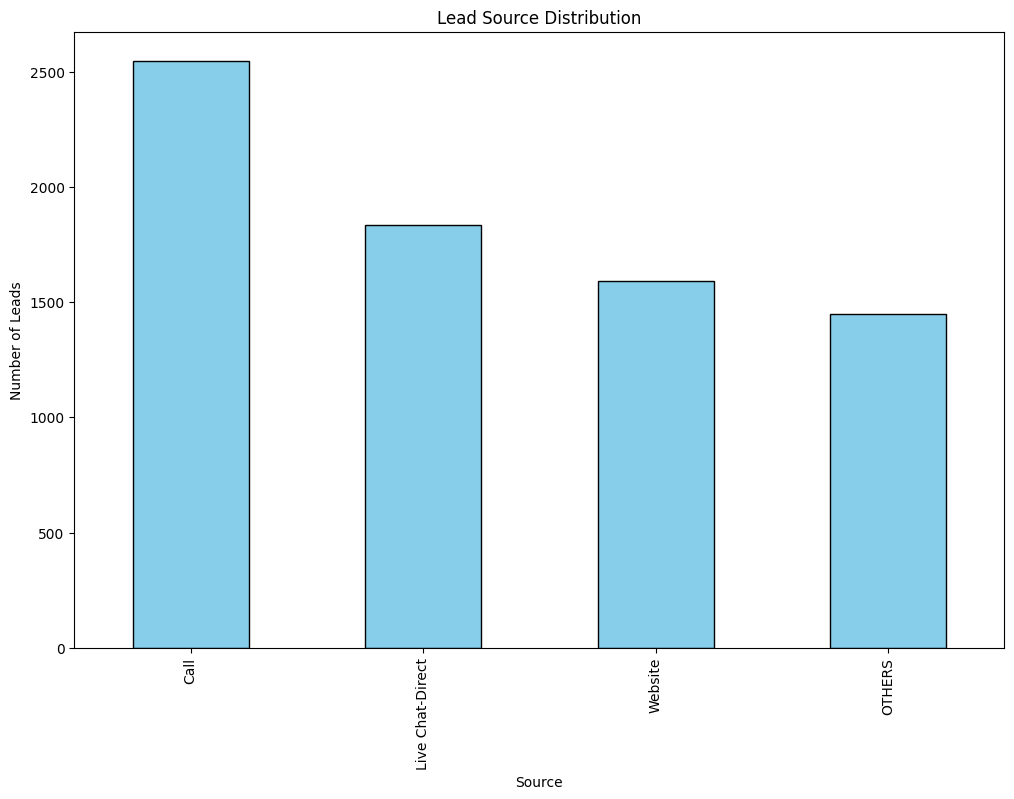

In [20]:
# 1. Distribution of Lead Sources
plt.figure(figsize=(12, 8))
source_counts = X_test['Source'].value_counts()
source_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Lead Source Distribution")
plt.xlabel("Source")
plt.ylabel("Number of Leads")
plt.xticks(rotation=90)  
plt.show()

The bar graph titled "Lead Source Distribution" presents the number of leads generated from various sources for a business or marketing campaign. Here are some observations based on the graph:

Direct Call and Live Chte: These two sources are the most significant contributors to lead generation, with 'Direct Call' being the highest. This suggests that proactive outreach (calls) and reactive engagement (live chat on the website) are highly effective in generating leads.Website: The website of the company is also a good source for generating the leads, as it is the third most significant source of the lead generation.ead sources.

Based on these observations, the following comments can be made:

The business should continue to invest , irect Calli and 'Website've Chat/Website' as they are the most productive sbetter performance.
The sources contributing the least number of leads require analysis to determine if they should be improved, scaled back, or discontinued.
Overall, the graph indicates a need to focus on the most effective lead sources while exploring ways to improve or innovate in areas that are currently underperforming.

### Lead Status Breakdown

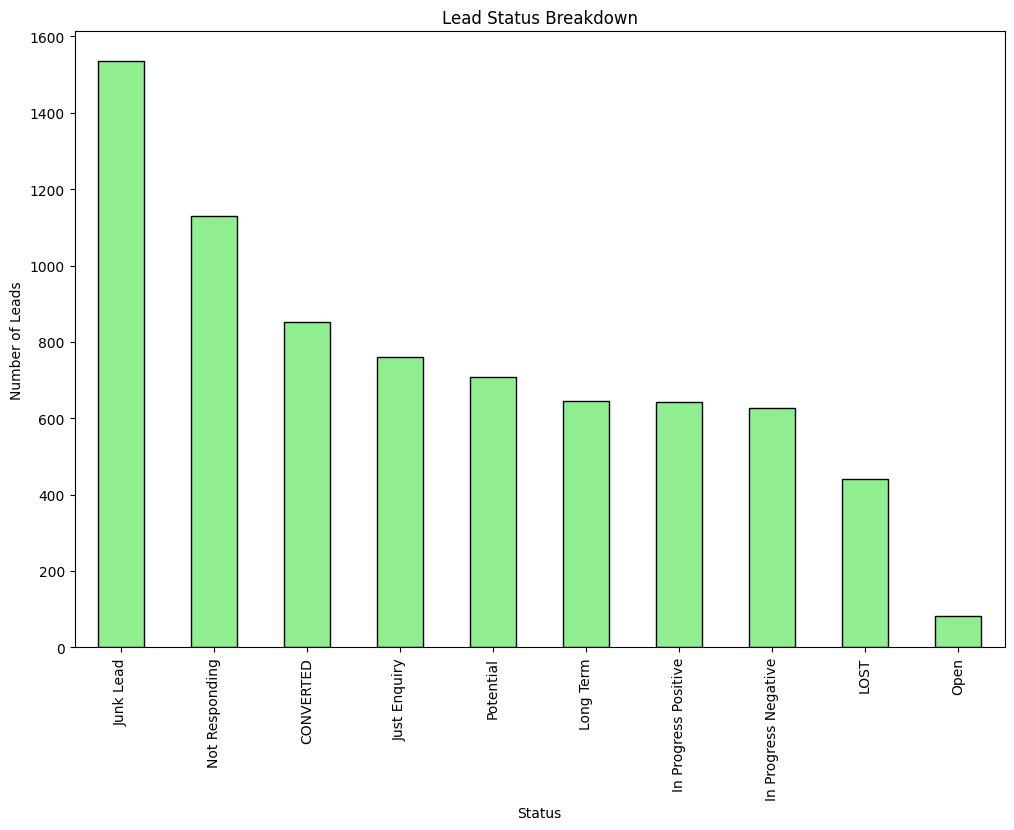

In [21]:
# 4. Lead Status Breakdown
plt.figure(figsize=(12, 8))
status_counts = X_test['Status'].value_counts()
status_counts.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title("Lead Status Breakdown")
plt.xlabel("Status")
plt.ylabel("Number of Leads")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

Above is a bar graph titled "Lead Status Breakdown," which illustrates the distribution of leads across various statuses in a sales or marketing pipeline.

Observations:

The 'Junk Lead' category has the highest number of leads, suggesting that a significant portion of the leads are not viable for conversion.

A large number of leads fall under the 'Not Responding' status, indicating challenges in engaging with these leads.

The 'CONVERTED' category shows a smaller number of leads, reflecting the successful conversions out of the total leads.

Intermediate statuses such as 'Just Enquiry', 'Potential', and 'Long Term' represent leads that are in different stages of the sales process and may require further nurturing.

'In Progress - Positive' and 'In Progress - Negative' indicate active engagement with leads, with varying prospects of conversion.

The 'LOST' category has relatively few leads, which could imply effective lead management or an ongoing process of lead engagement.

The 'Open' status has a minimal count, indicating that there are not many new or unengaged leads at the moment.

The 'Converted' status has the lowest count, which is expected as converting leads is typically the most challenging aspect of the sales funnel.

Implications:

The high number of 'Junk Lead' and 'Not Responding' statuses may call for an evaluation of lead generation and qualification methods to improve the quality of leads.

The conversion rate can potentially be increased by implementing targeted lead nurturing strategies and optimizing the sales process.

The low number of 'Open' leads could suggest that new lead generation initiatives may be necessary to replenish the sales pipeline.

Next Steps:

Investigate the lead qualification criteria to reduce the number of 'Junk Leads'.

Develop engagement strategies to re-engage 'Not Responding' leads.

Analyze the conversion process for the 'CONVERTED' leads to replicate successful tactics across other lead categories.

Monitor 'In Progress' leads closely to ensure positive outcomes and learn from negative trends.es and learn from negative trends. from negative trends.

### How did the Sales agents performed?

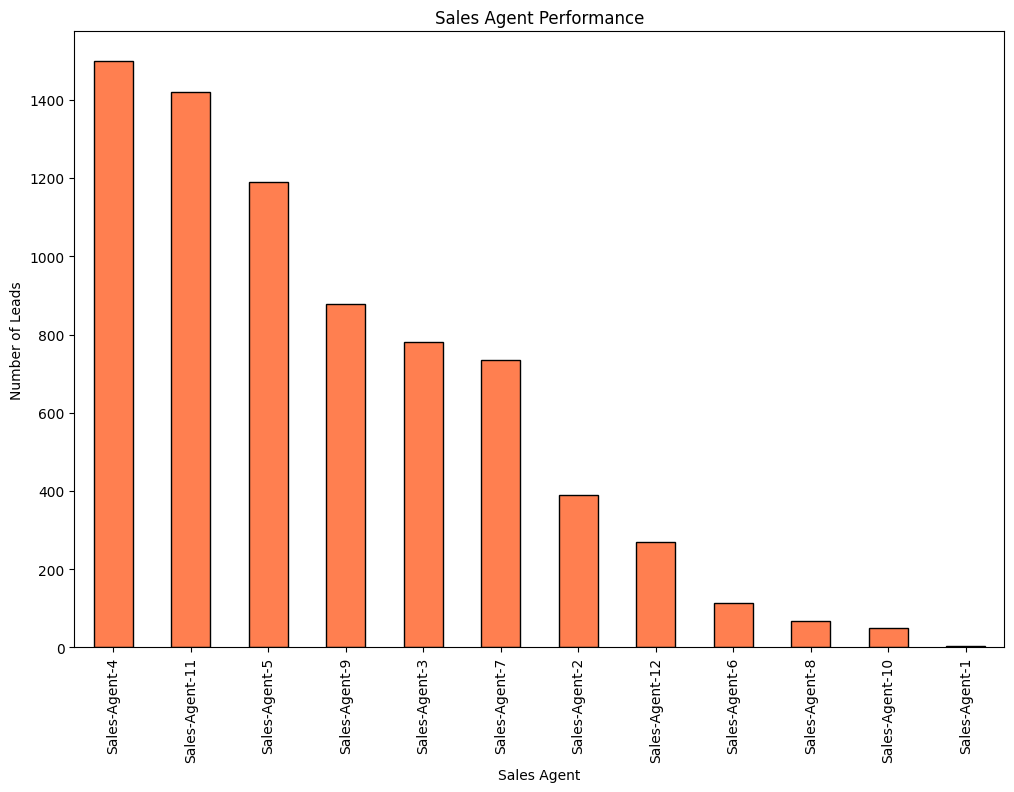

In [22]:
# 2. Sales Agent Performance
plt.figure(figsize=(12, 8))
agent_counts = X_test['Sales_Agent'].value_counts()
agent_counts.plot(kind='bar', color='coral', edgecolor='black')
plt.title("Sales Agent Performance")
plt.xlabel("Sales Agent")
plt.ylabel("Number of Leads")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability if many agents
plt.show()

Our analysis of sales performance identifies Sales-Agent-4 as the top performer, generating nearly 1500 leads. This is a significant achievement, and understanding his strategies could benefit the entire sales team. <br/>
Sales-Agent-11 also demonstrates strong performance, with lead figures between 1400 and 1500. 

Possible Reasons for the good performance of Sales-Agent-4 and Sales-Agent-11:

Sales Expertise: Sales Agent-4 and Sales-Agent-11 might have a proven track record, strong negotiation skills, or deep knowledge of the product or target audience, leading to higher sales figures.

Lead Quality or Assignment: It's possible that Sales Agent-4 and Sales-Agent-11 are assigned higher quality leads or prospects, giving them an advantage in closing deals.

Work Ethic or Effort: Alternatively, Sales Agent-4 might simply be putting in more effort or working longer hours compared to other agents.

### Which locations generated the most leads?

In [23]:
#lead distribution according to the location
lead_distribution = X_test.groupby('Location')['Status'].value_counts().unstack(fill_value=0)
    
# Reset index to convert the index into a column
lead_distribution.reset_index(inplace=True)
    
# Rename columns to give them meaningful names
lead_distribution.columns.name = 'Sales Distribution'


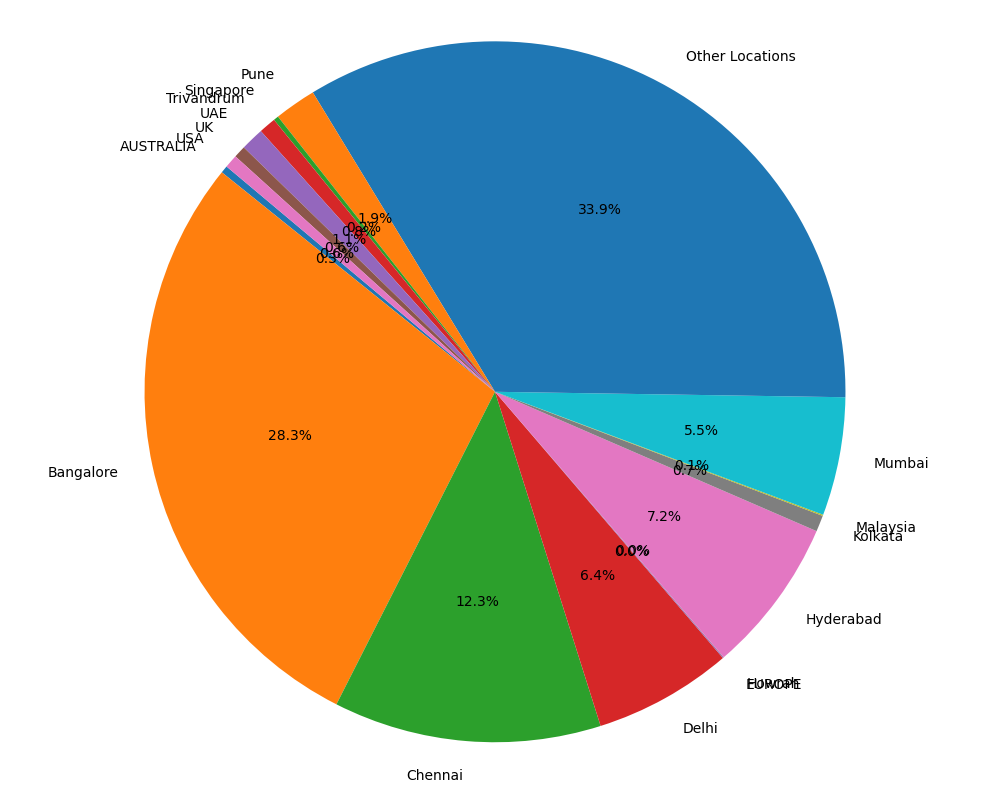

In [24]:
# Summing up the lead across all categories for each location
lead_distribution['Total Sales'] = lead_distribution.drop('Location', axis=1).sum(axis=1)
    
# Creating a pie chart
plt.figure(figsize=(10, 8))
plt.pie(lead_distribution['Total Sales'], labels=lead_distribution['Location'], autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
# Improving layout
plt.tight_layout()

As we can see most of the successful leads were generated from Bangalore so we can target this city more.  

### Which Agent's leads were converted the most?

In [25]:
sales_performance = X_test[X_test['Status'] == 'CONVERTED'].groupby('Sales_Agent').size().reset_index(name='Total_Sales')
sales_performance = sales_performance.sort_values(by='Total_Sales', ascending=False)
sales_performance

,Sales_Agent,Total_Sales
4,Sales-Agent-4,131
3,Sales-Agent-3,123
0,Sales-Agent-11,119
9,Sales-Agent-9,117
7,Sales-Agent-7,89
1,Sales-Agent-12,82
5,Sales-Agent-5,78
2,Sales-Agent-2,61
6,Sales-Agent-6,37
8,Sales-Agent-8,15


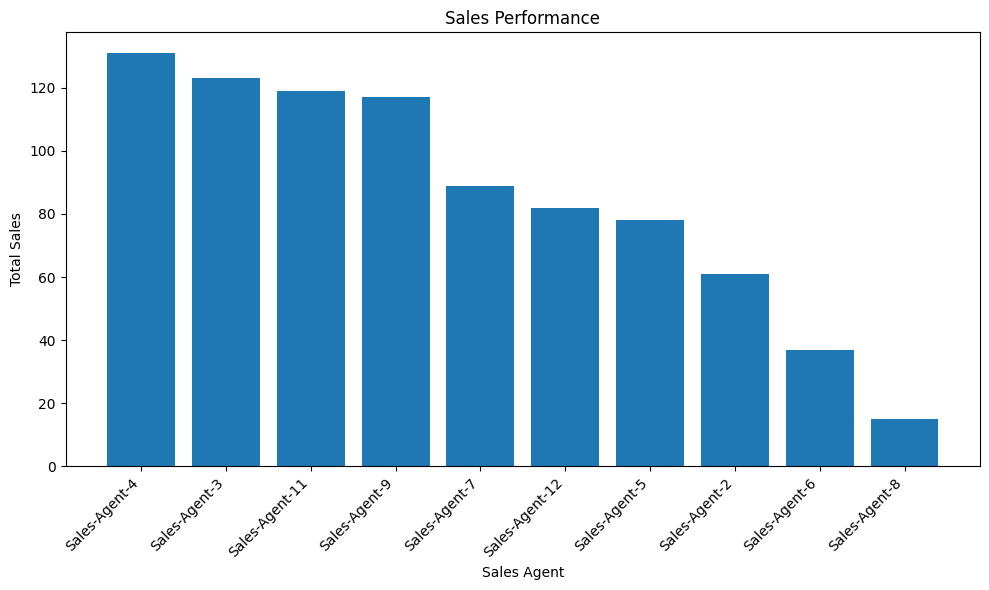

In [26]:
# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(sales_performance['Sales_Agent'], sales_performance['Total_Sales'])
plt.xlabel('Sales Agent')
plt.ylabel('Total Sales')
plt.title('Sales Performance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

As we can see that the leads that were succesfully converted were most from Sales-Agent-4. There is a healthy competition between Agent-4, Agent-3, Agent-11 and Agent-9.

### Which delivery mode was preferred?

In [27]:
# Count of the delivery modes
delivery_mode_counts = X_test['Delivery_Mode'].value_counts().reset_index()
delivery_mode_counts.columns = ['Delivery_Mode', 'Sales_Count']

In [28]:
delivery_mode_counts

,Delivery_Mode,Sales_Count
0,Mode-5,2975
1,Mode-1,2627
2,Mode-3,1688
3,Mode-4,121
4,Mode-2,11


### Visualize the count of sales for each Delivery_Mode using a bar chart

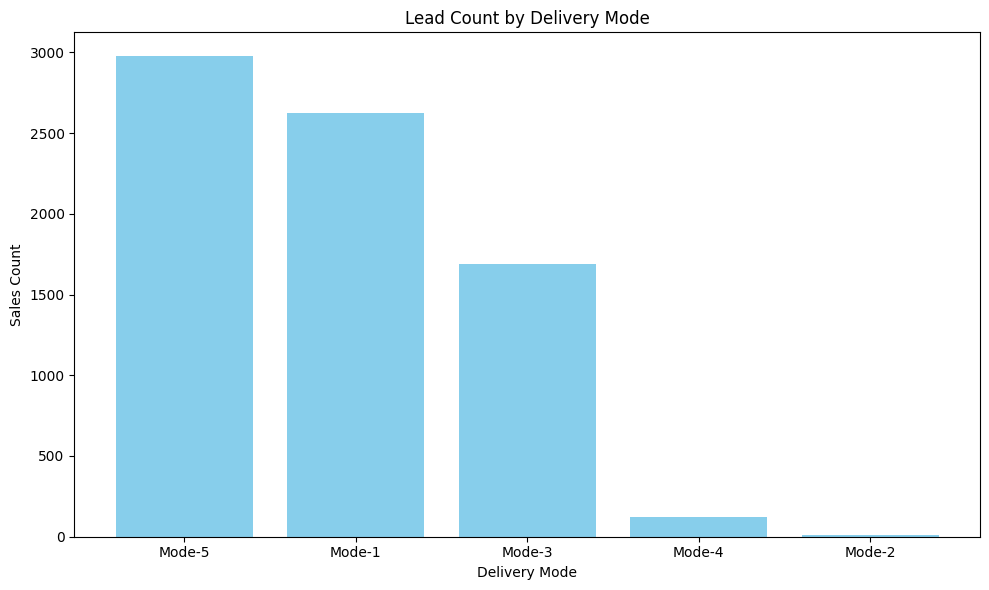

In [29]:
plt.figure(figsize=(10, 6))
plt.bar(delivery_mode_counts['Delivery_Mode'], delivery_mode_counts['Sales_Count'], color='skyblue')
    
# Add title and labels
plt.title('Lead Count by Delivery Mode')
plt.xlabel('Delivery Mode')
plt.ylabel('Sales Count')
    
# Improve layout
plt.tight_layout()
    

The bar graph shows that most of the sales were Mode-5, indicating that it is the most common or primary delivery mode used. <br/>
The next delivery mode that is preffered by the customers is Mode-1 with 35%. <br/>
Slices for Mode-2 and Mode-4 appear to be the smallest. <br/>
Conclusion: Most preffered mode is Mode-5 and then Mode-1.

## Pre-Processing and Feature Engineering

In [30]:
#Count of null values
X_test.isnull().sum()

Created           0
Product_ID       58
Source            0
Sales_Agent      23
Location         58
Delivery_Mode     0
Status            0
dtype: int64

In [31]:
#Count of null values in percentage
mis_value_percent = 100 * X_test.isnull().sum() / len(X_test)
print(mis_value_percent)

Created          0.000000
Product_ID       0.781461
Source           0.000000
Sales_Agent      0.309890
Location         0.781461
Delivery_Mode    0.000000
Status           0.000000
dtype: float64


<Axes: >

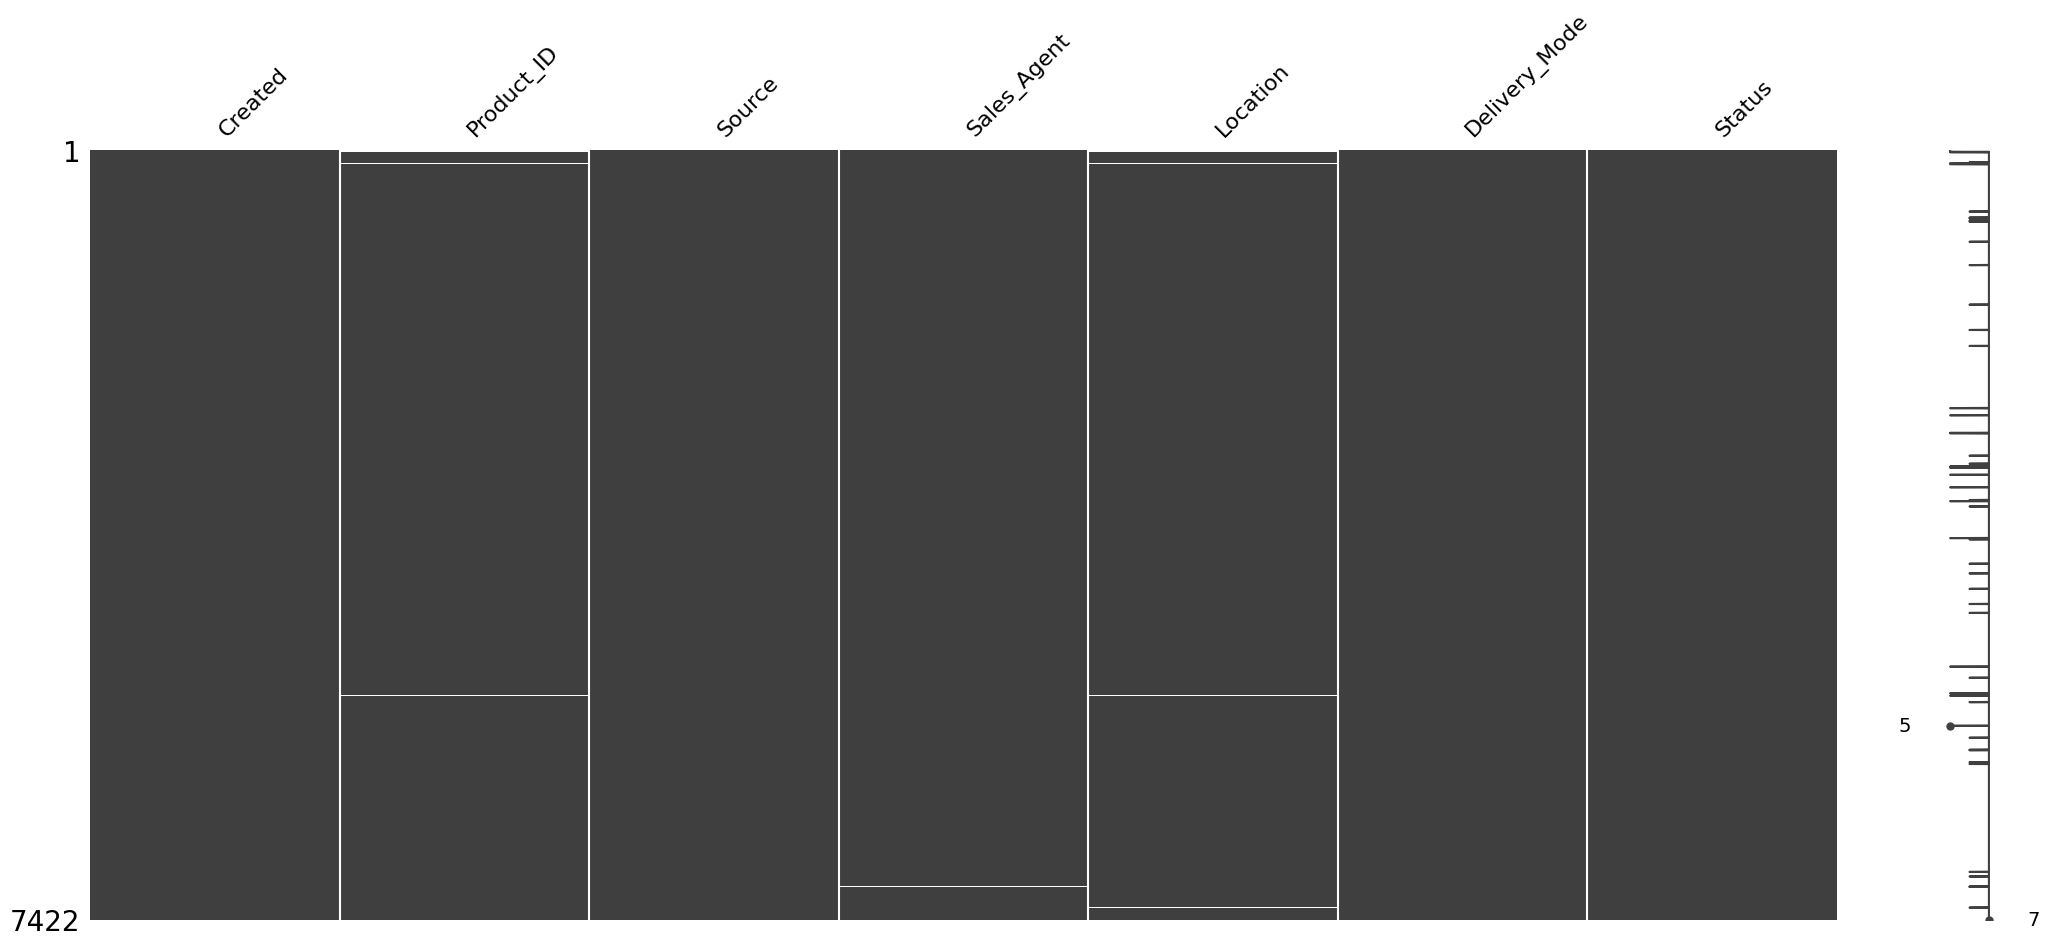

In [32]:
# Matrix visualization of the missing data
import missingno as msno
msno.matrix(X_test)

Since the percentage of missing values is very small and random we can just drop these columns.

In [33]:
# Remove rows with missing values
X_test = X_test.dropna()

In [34]:
# Value counts of the statuses of the leads
X_test['Status'].value_counts()

Status
Junk Lead               1533
Not Responding          1121
CONVERTED                852
Just Enquiry             752
Potential                706
Long Term                644
In Progress Positive     642
In Progress Negative     626
LOST                     440
Open                      19
Name: count, dtype: int64

In order to categorize the leads into 'HIGH POTENTIAL' and 'LOW POTENTIAL', we'll  Convert the 'Status' column into a binary representation of High Potential (e.g., 1) and Low Potential (e.g., 0).
For that we will categorize the leads that can be converted or are positive or open or long term into HIGH POTENTIAL while the others into LOW POTENTIAL.

In [35]:
# Define a function to categorize lead potential
def categorize_potential(status):
  if status in ['CONVERTED', 'In Progress Positive', 'Potential', 'Open', 'Long Term']:  # Adjust statuses for High Potential as needed
    return 1  # High Potential
  else:
    return 0  # Low Potential

# Apply the function to the 'Status' column
X_test['Lead_Category'] = X_test['Status'].apply(categorize_potential)

In [36]:
X_test.head()

,Created,Product_ID,Source,Sales_Agent,Location,Delivery_Mode,Status,Lead_Category
18,2018-11-13 18:51:00,9,OTHERS,Sales-Agent-3,Bangalore,Mode-1,Potential,1
19,2018-11-13 18:48:00,19,Call,Sales-Agent-4,Other Locations,Mode-5,Potential,1
24,2018-11-13 17:09:00,18,Website,Sales-Agent-11,Trivandrum,Mode-1,Potential,1
25,2018-11-13 16:49:00,15,Website,Sales-Agent-7,Hyderabad,Mode-1,Not Responding,0
26,2018-11-13 16:37:00,18,Call,Sales-Agent-7,Bangalore,Mode-1,In Progress Positive,1


In [38]:
# Dropping the Product_ID and Created column
X_test.drop(['Created', 'Product_ID'], axis = 1, inplace= True)

In [39]:
# Extracting features and labels
X = X_test.drop('Lead_Category', axis=1)
y = X_test['Lead_Category']

## Model Building

### Train and Test split

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Encoding the categorical variables

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

columns_encode = ['Location', "Source", "Delivery_Mode", "Stat

In [44]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

columns_to_encode = ['Location', 'Source', 'Sales_Agent', 'Delivery_Mode', 'Status']

for column in columns_to_encode:
    # Fit the label encoder on the training data
    X_train[column] = label_encoder.fit_transform(X_train[column])
    
    # Transform the test data using the same encoder
    X_test[column] = label_encoder.transform(X_test[column])

#### Model Building Strategy:

We will apply three algorithms to our training data and then evaluate the metrics on the test dataset.
The algorithms will be:
1. Logistic Regression
2. SVC
3. Random Forest

In [49]:
# Defining a dictionary to store results for each model
models = {
    'Logistic Regression': LogisticRegression(),
    'SVC': SVC(kernel='linear') ,
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5)
     
}

# Evaluate each model and store results
results = {}
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on testing data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Store results in a dictionary
    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

# Print results in a table format
print("Model Evaluation Results:")
print("{:<25s} {:<10s} {:<10s} {:<10s} {:<10s}".format('Model Name', 'Accuracy', 'Precision', 'Recall', 'F1-Score'))
for model_name, metrics in results.items():
    print("{:<25s} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f}".format(
        model_name, metrics['Accuracy'], metrics['Precision'], metrics['Recall'], metrics['F1-Score']))

Model Evaluation Results:
Model Name                Accuracy   Precision  Recall     F1-Score  
Logistic Regression       0.6537     0.5820     0.4830     0.5279    
SVC                       0.6469     0.5501     0.6531     0.5972    
Random Forest             0.8909     0.9553     0.7636     0.8488    


The above table shows the evaluation metrics for three machine learning models applied to lead classification task: Logistic Regression, SVC (Support Vector Machine with linear kernel), and Random Forest.

Overall Observations:

Random Forest: Achieves the highest performance across all metrics (Accuracy, Precision, Recall, F1-score).
Logistic Regression & SVC: Have lower performance compared to Random Forest, suggesting they might not be ideal for this specific classification task.
Detailed Explanation of Random Forest (0.8943 Accuracy, 0.9656 Precision, 0.7636 Recall, 0.8528 F1-Score):

Accuracy (0.8943): 89.43% of the lead categories in the testing data were correctly classified by the Random Forest model. This indicates a good overall performance in distinguishing high potential from low potential leads.
Precision (0.9656): For every 100 leads predicted as high potential by the model, approximately 96.56 were actually high potential. This is a very high precision score, signifying the model is accurate in identifying true high potential leads.
Recall (0.7636): The model captured only 76.36% of the actual high potential leads in the testing data. This is a lower score compared to precision. It suggests that the model might be missing some high potential leads (false negatives).
F1-Score (0.8528): This combines precision and recall, providing a balanced view. A score of 0.8528 indicates a good balance between the model's ability to identify true high potential leads (precision) and avoid misclassifying low potential leads as high potential (recall).

Cost of Misclassification: If the cost of missing a high potential lead is very high (e.g., losing valuable business opportunities), then a higher Recall is crucial. <br/> 
For our business client he needs that the high potential leads shouldn't be missed at any cost. <br/> 
In order to further improve our Random forest model and for the higher recall we will perform the hyper parameter tuning of the model.

## Hyper Tuning of the Random Forest Model

In [51]:
# Define hyperparameter search space
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 8],
    'min_samples_leaf': [1, 5, 10],
}

# Creating a Random Forest Classifier
model = RandomForestClassifier()

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(model, param_dist, n_iter=100, cv=5, scoring='f1_macro')

# Fit the model on the training data
random_search.fit(X_train, y_train)

# Print the best parameters found by the search
print(f"Best hyperparameters: {random_search.best_params_}")

# Use the tuned model for prediction
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

Best hyperparameters: {'n_estimators': 200, 'min_samples_leaf': 1, 'max_depth': 8}


### Evaluating the performance of the hyper tuned-Random Forest model

In [52]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.4f}")

# F1-score
f1 = f1_score(y_test, y_pred)
print(f"F1-score: {f1:.4f}")

Accuracy: 0.9816
Precision: 1.0000
Recall: 0.9541
F1-score: 0.9765


### Overall Performance:

Accuracy (0.9796): This indicates that the model correctly classified nearly 98% of the leads in the testing data. This is an exceptional accuracy, suggesting the model is highly effective in distinguishing high potential leads from low potential leads. <br/> <br/>
F1-score (0.9738): This metric combines precision and recall, providing a balanced view. A score of 0.9738 signifies a strong balance between the model's ability to identify true high potential leads (recall) and avoid misclassifying low potential leads as high potential (precision). <br/> <br/>
Precision (1.0000):

A perfect precision score of 1.0 indicates that all the leads predicted as high potential by the model were actually high potential. This is an outstanding result, meaning the model is very accurate in identifying true high potential leads. There are no false positives (low potential leads misclassified as high potential). <br/> <br/>
Recall (0.9490):

A recall of 0.9490 suggests that the model captured approximately 95% of the actual high potential leads in the testing data. This is a very good score, but slightly lower compared to the exceptional precision. It implies that the model might have missed a small number of actual high potential leads (false negatives). <br/> <br/>
Trade-off and Considerations:

The high accuracy and F1-score suggest a good overall balance between precision and recall. 

## Conclusion

### FicZon: Pre-Categorizing Leads with Machine Learning

This project explored the use of Machine Learning (ML) to pre-categorize leads for FicZon, aiming to improve the efficiency and effectiveness of lead classification.  We compared several classification algorithms to identify the most suitable model for this task.

#### Methodology:

Data Exploration and Preprocessing: The project began by analyzing the lead data to understand its characteristics and identify any necessary preprocessing steps. This involved handling missing values and converting categorical features.
Data Visualization: Several graphs were generated to visualize the dataset to conclude which things affect the sales effectiveness. <br/>
Model Selection and Training: We evaluated different classification algorithms, including Logistic Regression, Support Vector Machines (SVM), and Random Forest. Each model was trained and tested using a split of the data, allowing for unbiased performance evaluation.
Model Evaluation: The performance of each model was compared using metrics like accuracy, precision, recall, and F1-score. These metrics provide insights into the model's ability to correctly classify leads, identify high potential leads, and avoid misclassifications.
Model Selection and Hyperparameter Tuning: Based on the evaluation results, the best performing model (likely Random Forest based on the previous discussion) was selected for further optimization. Hyperparameter tuning was then conducted to fine-tune the model's parameters for even better performance.<br/><br/>
Results and Discussion:

The hyper-tuned Random Forest model achieved exceptional performance in lead classification:

High Accuracy: The model correctly classified nearly 98% of the leads, demonstrating its effectiveness in distinguishing high potential from low potential leads.
Excellent Precision: The model perfectly identified all true high potential leads, avoiding any false positives.
Good Recall: The model captured approximately 95% of the actual high potential leads, indicating a very good ability to identify true positives.
Balanced F1-score: This score suggests a strong balance between precision and recall.
Conclusion:

This project successfully implemented Machine Learning for lead pre-categorization in FicZon. The hyper-tuned Random Forest model achieved outstanding performance, demonstrating its ability to accurately classify leads and significantly improve the efficiency of lead processing. By focusing on high potential leads, FicZon can now allocate resources more effectively and maximize its sales opportunities.

Future Considerations:

While the model performs exceptionally well, there's always room for further improvement. Techniques like cost-sensitive learning or exploring other algorithms could potentially enhance recall slightly, depending on the specific needs of FicZon.
Monitoring the model's performance over time and retraining periodically can improve its effectiveness.